In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import imageio
from IPython.display import display, Image

## Cellular Potts Model

In [2]:
def plot_timepoint(results, idx):
    """Plot a specific timepoint."""
    filename = f"out/cpm_{idx}"
    if idx < len(results):
        plt.imshow(results[idx], cmap="tab20")
        plt.title(f"Step {idx}")
        plt.savefig(filename)
        plt.show()

    else:
        print(f"Timepoint {idx} not available.")

def lattice_to_image(lattice):
    """Convert lattice to an RGB image for gif creation."""
    fig, ax = plt.subplots()
    ax.imshow(lattice, cmap="tab20")
    ax.axis('off')
    fig.tight_layout()
    
    # Convert the Matplotlib figure to an RGB array
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    img = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8).reshape(canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return img
    
def generate_gif(results, filename="out/simulation.gif"):
    """Generate a gif from the results."""
    with imageio.get_writer(filename, mode='I') as writer:
        for lattice in results:
            img = lattice_to_image(lattice)
            writer.append_data(img)

def display_gif(filename):
    """Display the GIF in a Jupyter Notebook."""
    with open(filename, "rb") as f:
        display(Image(data=f.read(), format="png"))


In [3]:
class CPM:
    def __init__(
        self, 
        size=100, 
        adhesion=1, 
        self_adhesion=1.5,
        temperature=1, 
        n_cells=10, 
        target_size=10, 
        save_steps=1
    ):
        self.L = size
        self.sites = self.L**2
        self.J = adhesion
        self.J_self = self_adhesion
        self.T = temperature
        self.n_cells = n_cells
        self.target_size = target_size
        self.save_steps = save_steps

        # Initialize
        self.lattice = np.zeros((self.L, self.L), dtype=int)
        self.initialize_cells(target_size=self.target_size)

        # Place to save results
        self.results = [self.lattice.copy(), ]

    def initialize_cells(self, target_size=5):
        if np.sum(self.lattice) != 0:  # reset lattice
            self.lattice = np.zeros((self.L, self.L), dtype=int)
        for cell_id in range(1, self.n_cells + 1):
            x, y = np.random.randint(0, self.L, 2)

            to_fill = target_size
            cell_sites = [(x, y)]
            self.lattice[x, y] = cell_id
            to_fill -= 1

            while to_fill > 0:
                xi, yi = cell_sites[np.random.randint(len(cell_sites))]
                dx, dy = [(0, 1), (0, -1), (1, 0), (-1, 0)][np.random.randint(4)]
                xn, yn = (xi + dx) % self.L, (yi + dy) % self.L

                if self.lattice[xn, yn] == 0:
                    self.lattice[xn, yn] = cell_id
                    cell_sites.append((xn, yn))
                    to_fill -= 1
    
    def delta_H(self, x, y, xi, yi):
        """Compute the change in Hamiltonian for a copy event."""
        current = self.lattice[x, y]
        target = self.lattice[xi, yi]

        # Check for self-adhesion
        if current == target:
            return -self.J_self
        # Different cells, use regular adhesion
        elif current != 0 and target != 0:
            return self.J
        else:
            return 0

    def metropolis(self, x, y, xi, yi):
        """Use Metropolis criterion to accept or reject a copy event."""
        dH = self.delta_H(x, y, xi, yi)
        if dH < 0:
            return True
        else:
            return np.random.rand() < np.exp(-dH/self.T)

    def run(self, n_steps):
        for step in range(n_steps):
            for _ in range(self.sites):
                x, y = np.random.randint(0, self.L, 2)
                direction = np.random.choice(['up', 'down', 'left', 'right'])
                
                if direction == 'up':
                    xi, yi = (x, (y+1)%self.L)
                elif direction == 'down':
                    xi, yi = (x, (y-1)%self.L)
                elif direction == 'left':
                    xi, yi = ((x-1)%self.L, y)
                else:
                    xi, yi = ((x+1)%self.L, y)
                
                if self.metropolis(x, y, xi, yi):
                    self.lattice[xi, yi] = self.lattice[x, y]
    
            # Save state
            if step % self.save_steps == 0:
                self.results.append(self.lattice.copy())

    def get_results(self):
        return self.results

In [10]:
total_time = 200
save_steps = 10
n_idx = int(total_time/save_steps)

cpm = CPM(
    size=40, 
    n_cells=12, 
    save_steps=save_steps,
    target_size=35,
    adhesion=1, 
    self_adhesion=1.5,
)
cpm.run(total_time)

results = cpm.get_results()

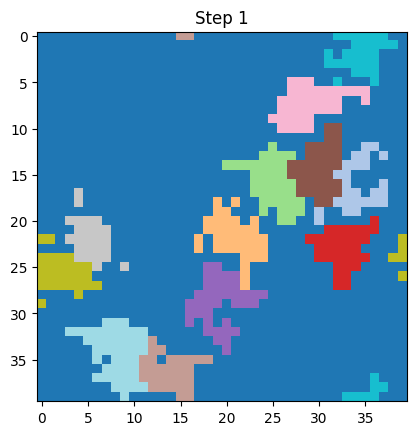

In [11]:
plot_timepoint(results, 1)

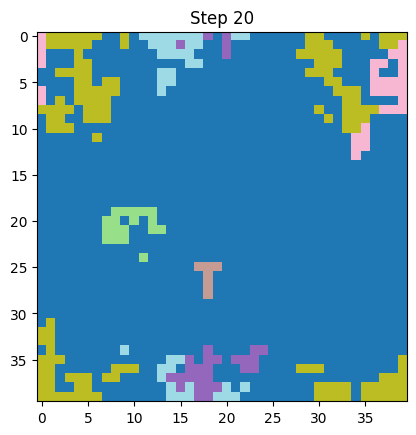

In [12]:
plot_timepoint(results, n_idx)

In [13]:
filename = "out/simulation.gif"
generate_gif(results, filename)

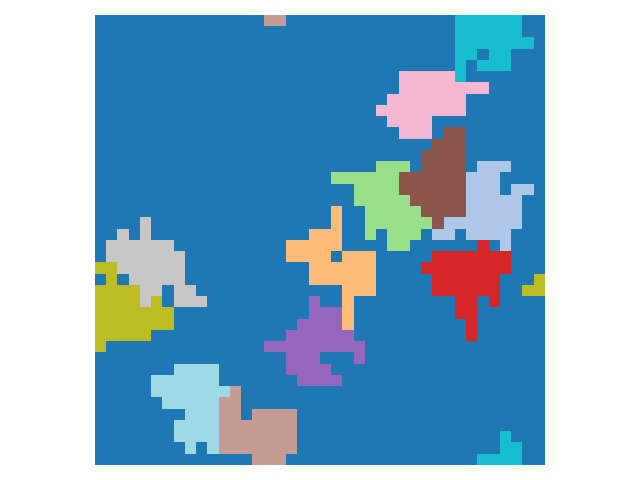

In [14]:
display_gif(filename)

## PDE for environment

In [15]:
class Diffusion2D:
    def __init__(
        self, 
        Lx=10.0, 
        Ly=10.0, 
        Nx=100, 
        Ny=100, 
        D=0.1, 
        dt=0.01
    ):
        self.Lx, self.Ly = Lx, Ly
        self.Nx, self.Ny = Nx, Ny
        self.dx = Lx / (Nx - 1)
        self.dy = Ly / (Ny - 1)
        self.D = D
        self.dt = dt

        self.u = np.zeros((Nx, Ny))

    def set_initial_conditions(self, func):
        """Set initial conditions based on a function."""
        for i in range(self.Nx):
            for j in range(self.Ny):
                x, y = i * self.dx, j * self.dy
                self.u[i, j] = func(x, y)

    def step(self):
        """Advance one timestep."""
        u_new = self.u.copy()
        for i in range(1, self.Nx - 1):
            for j in range(1, self.Ny - 1):
                duxx = (self.u[i + 1, j] - 2 * self.u[i, j] + self.u[i - 1, j]) / self.dx**2
                duyy = (self.u[i, j + 1] - 2 * self.u[i, j] + self.u[i, j - 1]) / self.dy**2
                u_new[i, j] = self.u[i, j] + self.D * self.dt * (duxx + duyy)
        self.u = u_new

    def run(self, num_steps):
        """Run the simulation for a specified number of steps."""
        for _ in range(num_steps):
            self.step()

    def plot(self, filename=None):
        """Visualize the current state."""
        plt.imshow(self.u, extent=[0, self.Lx, 0, self.Ly], origin='lower')
        plt.colorbar()
        # plt.title("2D Diffusion")
        if filename:
            plt.savefig(filename, dpi=300)
        plt.show()

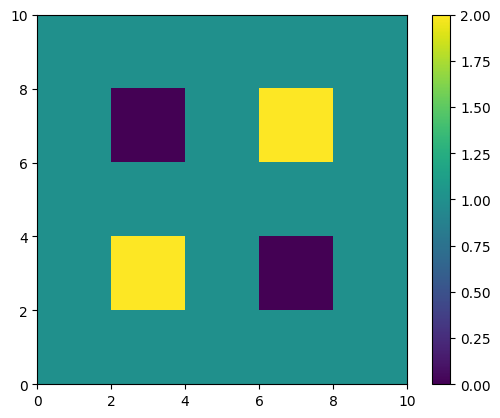

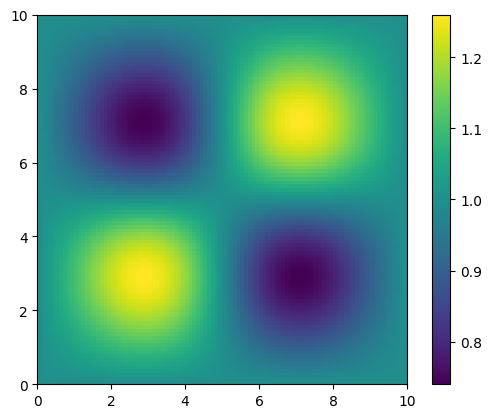

In [16]:
length = 10
bins = 100
total_time = 1000

# Create diffusion instance
diffusion = Diffusion2D(
    Lx=length, 
    Ly=length,
    Nx=bins, 
    Ny=bins, 
)

# Define initial condition as a function
def initial_condition(x, y):
    if (length*0.6 < x < length*0.8) and (length*0.6 < y < length*0.8):
        return 2
    elif (length*0.2 < x < length*0.4) and (length*0.2 < y < length*0.4):
        return 2
    elif (length*0.2 < x < length*0.4) and (length*0.6 < y < length*0.8):
        return 0
    elif (length*0.6 < x < length*0.8) and (length*0.2 < y < length*0.4):
        return 0
    else:
        return 1

diffusion.set_initial_conditions(initial_condition)
diffusion.plot(filename=f'out/pde_t0')  # plot initial condition

# Run simulation and plot
diffusion.run(total_time)
diffusion.plot(filename=f'out/pde_t{total_time}')